

---



Just to get acess to the image pattern file

In [23]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab\ Notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


Not by default on Colab

In [24]:
!pip install osmnx
!pip install gpxpy

Loading required modules

In [25]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import osmnx as ox
from skimage.morphology import skeletonize
import gpxpy
import gpxpy.gpx
from datetime import datetime
from scipy import ndimage
from skimage import measure



---



all the functions

this loads the image and digitizes it
> this assumes background is white and pattern is in black.

In [26]:
def load_and_process_image(filename):
    """Load image and convert to binary for route extraction"""
    try:
        img = Image.open(filename)
        print(f"Loaded image: {img.size}")
        #
        gray_img = img.convert('L')
        gray_img_np = np.array(gray_img)
        ret, binary_img = cv2.threshold(gray_img_np, threshold_val, 255, cv2.THRESH_BINARY_INV)
        #
        return img, binary_img
        #
    except FileNotFoundError:
        print(f"Error: {filename} not found.")
        return None, None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None

this attempts to get the boundary/perimeter of the pattern in png file as a continuous path

In [27]:
def extract_outline(binary_img):
    #
    kernel_clean = np.ones((3,3), np.uint8)
    binary_cleaned = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel_clean)
    binary_cleaned = cv2.morphologyEx(binary_cleaned, cv2.MORPH_OPEN, kernel_clean)
    #
    contours, _ = cv2.findContours(binary_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #
    if not contours:
        print("No contours found!") # fucked
        return None
    #
    largest_contour = max(contours, key=cv2.contourArea)
    #
    outline_img = np.zeros_like(binary_img)
    cv2.drawContours(outline_img, [largest_contour], -1, 255, 1)  # thickness=1 for thin boundary
    #
    return outline_img

this create a thin line around the pattern by converting thick lines to single-pixel-wide.

In [28]:
def skeletonize_route(binary_img):
    skeleton = skeletonize(binary_img // 255)
    #
    skeleton_img = (skeleton * 255).astype(np.uint8)
    #
    kernel = np.ones((3,3), np.uint8)
    skeleton_img = cv2.morphologyEx(skeleton_img, cv2.MORPH_CLOSE, kernel)
    #
    return skeleton_img

this gets city map for bike routs form OpenStreetMaps

In [29]:
def create_city_map():
    print("Downloading city street network...")
    G = ox.graph_from_place(place_name, network_type='bike')
    return G

this tries to overlay the skeletonized route on city map with proper scaling

In [30]:
def overlay_route_on_map(skeleton_img, G, scale_factor=0.6, position_offset=(0.1, 0.2)):
    #
    fig, ax = ox.plot_graph(G, figsize=(15, 15), node_size=0, edge_color='blue',
                           edge_linewidth=1, bgcolor='white', show=False, close=False)
    #
    graph_xlim = ax.get_xlim()
    graph_ylim = ax.get_ylim()
    graph_width = graph_xlim[1] - graph_xlim[0]
    graph_height = graph_ylim[1] - graph_ylim[0]
    #
    img_height, img_width = skeleton_img.shape
    #
    max_route_width = graph_width * scale_factor
    max_route_height = graph_height * scale_factor
    #
    width_scale = max_route_width / img_width
    height_scale = max_route_height / img_height
    final_scale = min(width_scale, height_scale)
    #
    new_width = img_width * final_scale
    new_height = img_height * final_scale
    #
    offset_x, offset_y = position_offset
    route_right = graph_xlim[1] - (graph_width * offset_x)
    route_left = route_right - new_width
    route_bottom = graph_ylim[0] + (graph_height * offset_y)
    route_top = route_bottom + new_height
    #
    rgba_img = np.zeros((img_height, img_width, 4), dtype=np.uint8)
    rgba_img[skeleton_img > 0] = [255, 0, 0, 255]  # Red route
    #
    extent = (route_left, route_right, route_bottom, route_top)
    ax.imshow(rgba_img, extent=extent, alpha=0.8, zorder=10)
    #
    plt.title("pattern as route mapped to city street network", fontsize=16)
    plt.show()
    #
    return rgba_img, extent

this creates GPS coordinate for the pattern recognized, should follow the sequence

In [31]:
def extract_route_coordinates(rgba_img, extent):
    left, right, bottom, top = extent
    height, width, _ = rgba_img.shape
    #
    lon_per_pixel = (right - left) / width
    lat_per_pixel = (top - bottom) / height
    #
    route_pixels = []
    for y in range(height):
        for x in range(width):
            if np.array_equal(rgba_img[y, x], [255, 0, 0, 255]):
                route_pixels.append((x, y))
    #
    if not route_pixels:
        return []
    #
    route_pixels = np.array(route_pixels)
    #
    ordered_pixels = order_boundary_pixels(route_pixels)
    #
    coords = []
    for x, y in ordered_pixels:
        latitude = top - (y + 0.5) * lat_per_pixel
        longitude = left + (x + 0.5) * lon_per_pixel
        coords.append((latitude, longitude))
    #
    return coords

this does the magic: orders pixels to follow the boundary path sequentiall

In [32]:
def order_boundary_pixels(pixels):
    if len(pixels) == 0:
        return []
    #
    start_idx = np.argmin(pixels[:, 0])  # leftmost pixel
    ordered = [pixels[start_idx]]
    remaining = list(range(len(pixels)))
    remaining.remove(start_idx)
    #
    current_pixel = pixels[start_idx]
    #
    while remaining:
        distances = []
        for idx in remaining:
            pixel = pixels[idx]
            #
            dist = np.sqrt((current_pixel[0] - pixel[0])**2 + (current_pixel[1] - pixel[1])**2)
            distances.append((dist, idx))

        #
        distances.sort()
        #
        chosen_idx = None
        for dist, idx in distances:
            if dist <= 2.0:
                chosen_idx = idx
                break
        if chosen_idx is None:
            #
            chosen_idx = distances[0][1]
        current_pixel = pixels[chosen_idx]
        ordered.append(current_pixel)
        remaining.remove(chosen_idx)
    return ordered

this creates GPX file

In [33]:
def create_gpx_file(coordinates, filename_prefix="rout"):
    if not coordinates:
        print("No coordinates to save!")
        return None
    #
    gpx = gpxpy.gpx.GPX()
    gpx_track = gpxpy.gpx.GPXTrack()
    gpx.tracks.append(gpx_track)
    gpx_segment = gpxpy.gpx.GPXTrackSegment()
    gpx_track.segments.append(gpx_segment)
    #
    for lat, lon in coordinates:
        gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(lat, lon))
    #
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    output_filename = f"{filename_prefix}_{timestamp}.gpx"
    #
    with open(output_filename, 'w') as f:
        f.write(gpx.to_xml())
    print(f"GPX route saved to: {output_filename}")
    return output_filename

let's see what it did

In [34]:
def visualize_final_route(G, coordinates):
    fig, ax = ox.plot_graph(G, figsize=(15, 15), node_size=0, edge_color='lightblue',
                           edge_linewidth=0.5, bgcolor='white', show=False, close=False)
    #
    if coordinates:
        lats = [coord[0] for coord in coordinates]
        lons = [coord[1] for coord in coordinates]
        #
        ax.scatter(lons, lats, c='red', s=10, alpha=0.7, label=f'Route ({len(coordinates)} points)')
        #
        ax.plot(lons, lats, 'red', linewidth=2, alpha=0.6)
        #
    ax.set_title("final route - GPS coordinates on city map", fontsize=16)
    ax.legend()
    plt.show()



---



update the value to populate the pattern in the image.
> the larger the value the more datapoint being collected.

In [35]:
threshold_val = 250

In [36]:
place_name = "Vancouver, BC, Canada"

In [37]:
filename = "BaBaE.png"  # image filename

start processing image and detect boundary

Step 1: Loading and processing image...
Loaded image: (806, 735)
Step 2: Extracting boundary outline...
Step 3: Preparing boundary route...


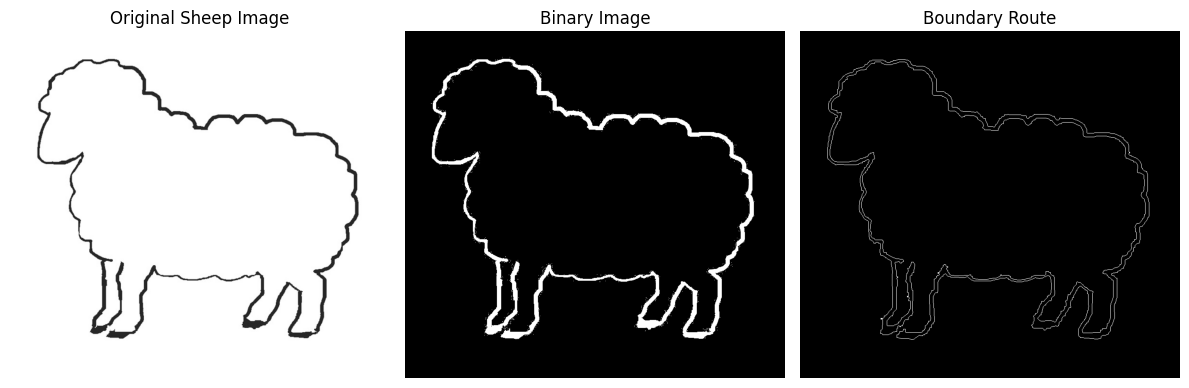

In [38]:
print("Step 1: Loading and processing image...")
original_img, binary_img = load_and_process_image(filename)
#
if binary_img is None:
  print("Failed to load image. Please check the filename and try again.")
#
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(original_img, cmap='gray')
plt.title('Original Sheep Image')
plt.axis('off')
#
plt.subplot(1, 3, 2)
plt.imshow(binary_img, cmap='gray')
plt.title('Binary Image')
plt.axis('off')
# --------------------------------------------------------------------------------
print("Step 2: Extracting boundary outline...")
outline_img = extract_outline(binary_img)
#
if outline_img is None:
  print("Failed to extract outline. Using original binary image.")
  outline_img = binary_img
# --------------------------------------------------------------------------------
print("Step 3: Preparing boundary route...")
kernel = np.ones((2,2), np.uint8)
skeleton_img = cv2.morphologyEx(outline_img, cv2.MORPH_CLOSE, kernel)
#
plt.subplot(1, 3, 3)
plt.imshow(skeleton_img, cmap='gray')
plt.title('Boundary Route')
plt.axis('off')
plt.tight_layout()
plt.show()

> **make sure boundary route looks good and connected. update `threshold_val` if needed**.

Download city map

In [39]:
print("Step 4: Creating street network...")
G = create_city_map()

Step 4: Creating street network...


overlaying route on city map

Step 5: Overlaying route on city map...


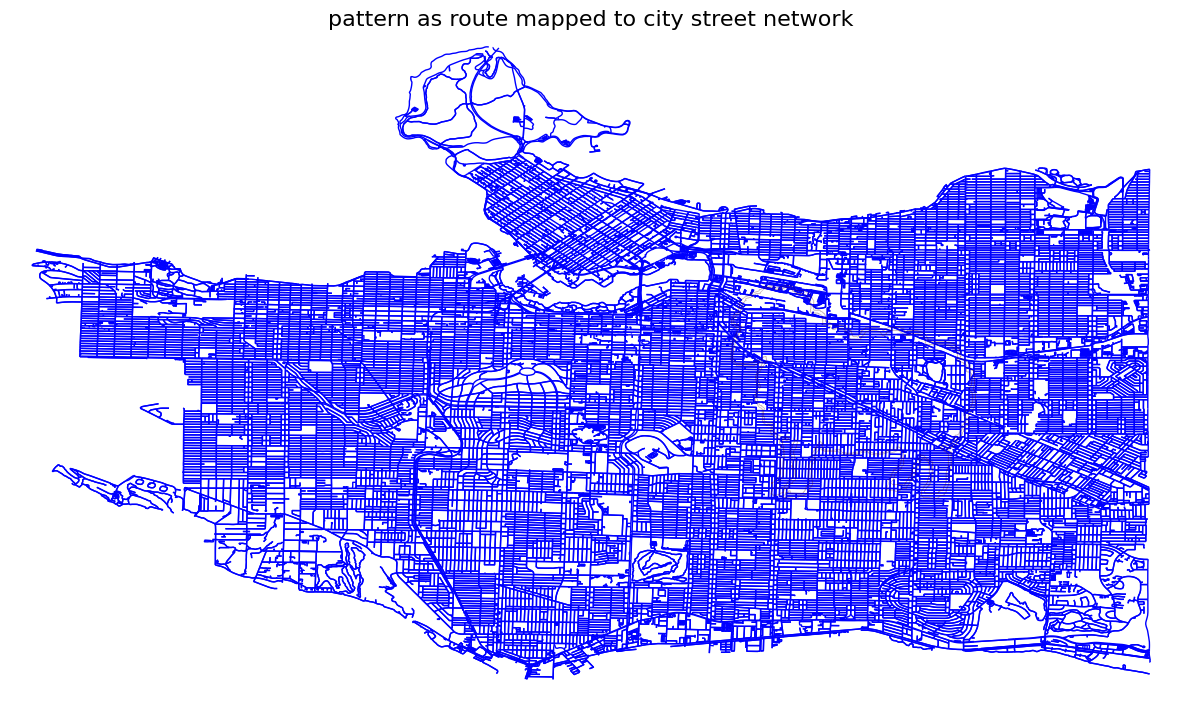

In [40]:
print("Step 5: Overlaying route on city map...")
rgba_img, extent = overlay_route_on_map(skeleton_img, G, scale_factor=0.4, position_offset=(0.15, 0.25))

GPS coordinates

In [41]:
print("Step 6: Converting to GPS coordinates...")
route_coordinates = extract_route_coordinates(rgba_img, extent)

Step 6: Converting to GPS coordinates...


GPX file

In [42]:
print("Step 7: Creating GPX file...")
gpx_filename = create_gpx_file(route_coordinates, "route")

Step 7: Creating GPX file...
GPX route saved to: route_2025-06-24_22-40-06.gpx


visualization

Step 8: Creating final route visualization...


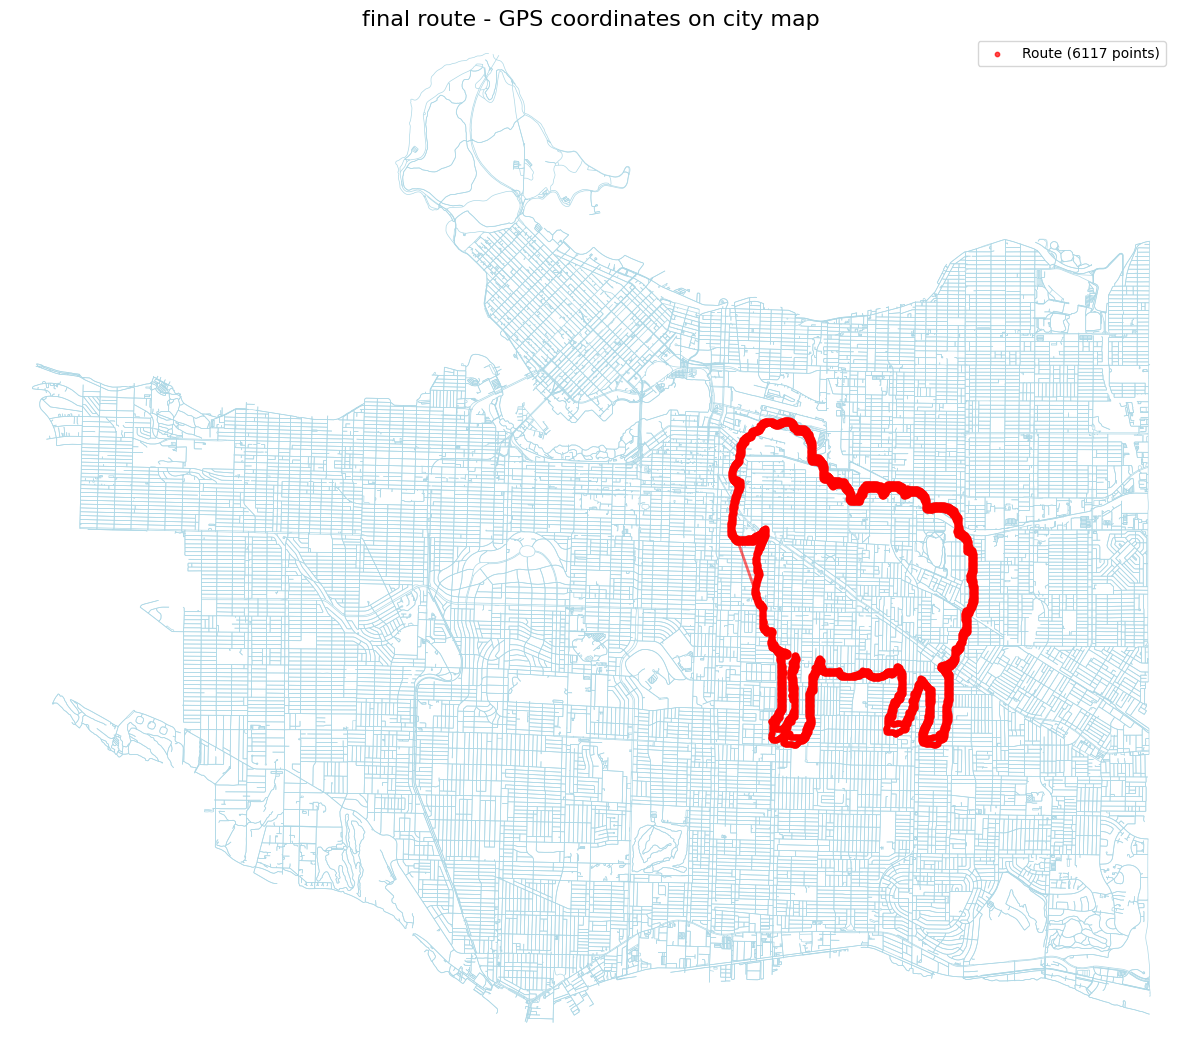

In [43]:
print("Step 8: Creating final route visualization...")
visualize_final_route(G, route_coordinates)

Summary

In [44]:
print("\n" + "="*60)
print("CONVERSION COMPLETE!")
print("="*60)
if route_coordinates:
    print(f"✓ Successfully extracted {len(route_coordinates)} GPS points")
    print(f"✓ GPX file saved: {gpx_filename}")
    print("✓ Route can now be imported into GPS devices or mapping apps")
else:
    print("⚠ No route coordinates were extracted. Check your input image.")


CONVERSION COMPLETE!
✓ Successfully extracted 6117 GPS points
✓ GPX file saved: route_2025-06-24_22-40-06.gpx
✓ Route can now be imported into GPS devices or mapping apps
